# Tutorial on PnP-LADMM

#### Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from torchvision.transforms import GaussianBlur


import torch
from torchmetrics.image import TotalVariation
from torchmetrics.functional.image import image_gradients

from metricas import *
from forward_autograd.degradacion import *
from drunet.network_unet import UNetRes as net

#### Data-loading

In [2]:
#x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_real = np.zeros((250,250))
x_real = torch.tensor(x_real)

In [3]:
def T_linea(dim_filas, dim_columnas, x):
    return forward(dim_filas, dim_columnas, x)

In [13]:
#y = T_linea(x_real.shape[0], x_real.shape[1], x_real[3,:])
#print(y.shape)

In [6]:
model_path = os.path.join('./drunet/drunet_gray.pth')
model = net(in_nc=1+1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
            v.requires_grad = False

In [7]:
def get_rho_sigma(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32)
    sigmas = (modelSigmaS*w+modelSigmaS_lin*(1-w))/255.
    return sigmas

In [8]:
noise_level_model =  7.65/255.0
iter_num = 8
modelSigma1 = 49
modelSigma2 = noise_level_model * 255.0
sigma = get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
sigmas = torch.tensor(sigma)

In [9]:
# convert uint (HxWxn_channels) to 4-dimensional torch tensor
def uint2tensor4(img):
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().div(255.).unsqueeze(0)

#### Creation of the model

In [10]:
def minimizeViaTorch(funcion_objetivo, x0, x_filas, x_columnas, lr=0.1, max_iter=10_000, eps=1e-6):

    params = x0
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=lr)

    diff = torch.inf

    k = 0

    while (k < max_iter) and (diff > eps):

        print(f"k: {k}, diff: {diff}", end="\r", flush=True)

        params_ant = params.detach().clone()

        optimizer.zero_grad()
        loss = funcion_objetivo(x_filas, x_columnas, params)
        loss.backward(retain_graph=True)
        optimizer.step()

        params_sig = params.detach().clone()

        diff = torch.norm(params_sig - params_ant)

        k += 1

    print("\n\n")

    return params.detach().clone()

#### Run model

ATENCIÓN: La siguiente celda puede llegar a demorar más de media hora dependiendo del hardware

In [15]:
### INICIALIZO VARIABLES ###

eps = 1e-4
max_iter = 50

mu = 1
sigma2 = 1

diff_x = torch.inf

cant_filas = x_real.shape[0]

###SE VA TRABAJAR CON SOLO UNA LINEA. SE ELIJE LA LINEA 200. SE APILA LA DEGRADACION DE ESA LINEA VARIAS VECES PARA FORMAR IMAGEN y_img###
y_img = x_real.clone()
cant_filas = x_real.shape[0]
fila_200 = T_linea(x_real.shape[0], x_real.shape[1], x_real[200,:])
for i in range(cant_filas):
    y_img[i,:] = fila_200

#x y z se inicializan iguales a y_img
x = y_img.clone()
z = x.clone()
x_sig_img = x.clone()

y = y_img[200,:]

### TERMINO DE INICIALIZAR VARIABLES ###

x_filas = x.shape[0]
x_columnas = x.shape[1]

nIter = 0
while (nIter <= max_iter) and (diff_x) > eps:

    print(f"Iteracion: {nIter}/{max_iter}", end="\r", flush=True)
    print(f"\ndiff_x: {diff_x}")
    
    z = z[200,:]
    fila_i_esima = torch.tensor(x[200,:], dtype=torch.float32, requires_grad = True)
    def actualizacion_fila_x(x_filas, x_columnas, x_param_linea):
        return torch.norm(y - T_linea(x_filas, x_columnas, x_param_linea))**2 + mu*sigma2*torch.norm(x_param_linea - z)**2
    # Actualizacion de x
    x_opt = minimizeViaTorch(actualizacion_fila_x, x0=fila_i_esima, x_filas = x_filas, x_columnas = x_columnas, lr=1e-4, max_iter=1e6, eps=1e-5)

    for i in range(cant_filas):
        x_sig_img[i,:] = x_opt

#PARA QUE CORRA MAS RAPIDO CORRERLO LO DE ARRIBA CON UNA LINEA Y DESPUES DUPLICAR HASTA FORMAR UNA IMAGEN

    x_sig_img = uint2tensor4(x_sig_img)

    # Actualizacion de z (.predict de red)
    x_sig_img = torch.cat((x_sig_img, sigmas[i].float().repeat(1, 1, x_sig_img.shape[2], x_sig_img.shape[3])), dim=1)
    z_sig_img = model(x_sig_img)

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_sig_img - x)

    # Asigno la actualizacion
    x = x_sig_img.clone()
    z = z_sig_img.clone()

    nIter += 1

print("\nTermino!")

Iteracion: 0/50
diff_x: inf


/var/folders/jy/11400q91501_8k9zvcqtlt_w0000gn/T/ipykernel_12494/3413589800.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fila_i_esima = torch.tensor(x[200,:], dtype=torch.float32, requires_grad = True)


k: 72, diff: 1.5270494259311818e-05




RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [15]:
x = normalize(x)
z = normalize(z)

In [ ]:
x = torch.where(x >= 0, x, 0)
x = torch.where(x <= 1, x, 1)

z = torch.where(z >= 0, z, 0)
z = torch.where(z <= 1, z, 1)

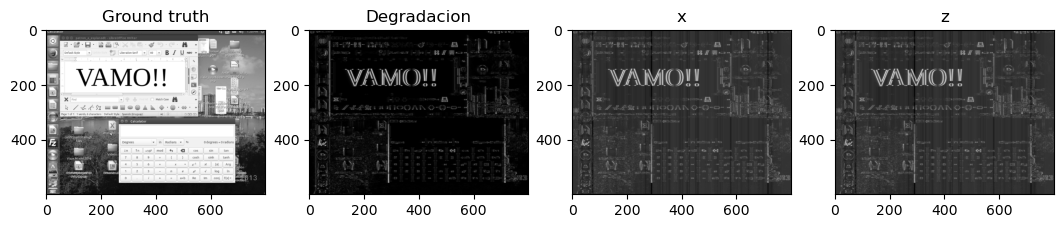

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(13,8))

axs[0].imshow(x_real, cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(y.detach(), cmap="gray")
axs[1].set_title("Degradacion")

axs[2].imshow(x.detach(), cmap="gray")
axs[2].set_title("x")

axs[3].imshow(z.detach(), cmap="gray")
axs[3].set_title("z")

plt.show()


#fig, axs = plt.subplots(1, 4, figsize=(13,8))

#axs[0].imshow(x_real, cmap="gray")
#axs[0].set_title("Ground truth")

#axs[1].imshow(1-y.detach(), cmap="gray")
#axs[1].set_title("Degradacion")

#axs[2].imshow(1-x.detach(), cmap="gray")
#axs[2].set_title("x")

#axs[3].imshow(1-z.detach(), cmap="gray")
#axs[3].set_title("z")

#plt.show()

In [ ]:
print("Ground truth:")
plt.figure(figsize=(10,8))
plt.imshow(x_real, cmap = 'gray')
plt.show()

print("Degradacion:")
plt.figure(figsize=(10,8))
plt.imshow(y.detach(), cmap = 'gray')
plt.show()

print("x:")
plt.figure(figsize=(10,8))
plt.imshow(x.detach(), cmap = 'gray')
plt.show()

print("z:")
plt.figure(figsize=(10,8))
plt.imshow(z.detach(), cmap = 'gray')
plt.show()

In [ ]:
print("x VS x_real")
print("="*30)

print(f"PSNR: {PSNR(x, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(x, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(x, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(x, x_real):0.4f}")

print()

print("y VS x_real")
print("="*30)

print(f"PSNR: {PSNR(y, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(y, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(y, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(y, x_real):0.4f}")

In [ ]:
imsave(f"./imagenes_restauradas/{img_file_name}", x.detach())

#### Grid-search

In [ ]:
import pandas as pd

In [ ]:
lams = [0, 0.5, 2, 5]
sigmas_energia = [0.01, 0.1, 1, 10]

df = pd.DataFrame(index=range(len(lams)*len(sigmas_energia)), columns=["lambda", "sigma", "PSNR", "SSIM", "MS-SSIM", "IW-SSIM"])

i = 0
for lam in lams:
    for sigma_energia in sigmas_energia:

        # Defino funciones con variables globales
        tv = TotalVariation()

        def f_energia(x):

            return (1/(2*sigma_energia**2)) * torch.norm(y - T_degradacion(x))**2

        def TV(x):

            x = x.unsqueeze(0).unsqueeze(0)

            return lam * tv(x)

        def L1(x):

            return lam * torch.norm(x, p=1)

        def L2(x):

            return lam * torch.norm(x, p=2)**2
        
        def grad_L2(x):

            return 2*lam*x

        def grad_L1(x):

            return lam * np.sign(x)

        def grad_TV(x, eps = 0.1):
            
            x = x.unsqueeze(0).unsqueeze(0)

            grad_x = image_gradients(x)

            norma_gradx = torch.norm(grad_x[0][0,0,:,:])
            norma_grady = torch.norm(grad_x[1][0,0,:,:])

            denominador = torch.sqrt(eps**2 + norma_gradx**2 + norma_grady**2).item()

            cociente_x = grad_x[0] / denominador
            cociente_y = grad_x[1] / denominador
            
            derivada_cociente_x = image_gradients(cociente_x)
            derivada_cociente_y = image_gradients(cociente_y)

            gradiente_tv = derivada_cociente_x[0][0,0,:,:] + derivada_cociente_y[1][0,0,:,:]

            return lam * gradiente_tv
        
        f = f_energia
        h = L2

        grad_h = grad_L2

        cte_h_lipz = 2*lam


        eps = 1e-6
        max_iter = 2_000

        Lz = round(cte_h_lipz + cte_h_lipz**2 + 3) + 1
        beta = max( cte_h_lipz + Lz + 2 , 3*(Lz**2 + cte_h_lipz**2)/((Lz + cte_h_lipz**2)/2) , 3*Lz**2) + 1
        Lx = round(beta + 6*cte_h_lipz**2 + 1) + 1

        diff_x = torch.inf
        diff_z = torch.inf
        diff_gamma = torch.inf

        #x = torch.zeros_like(x_real)
        #z = torch.ones_like(x_real)
        x = y.clone()
        z = x

        Nz = z.shape[0]

        gamma = torch.ones(x.shape)

        mat_inv = torch.from_numpy( np.linalg.inv(Lz + beta*np.identity(Nz)))


        nIter = 1

        while (nIter <= max_iter) and (max(diff_x, diff_z, diff_gamma) > eps):

            print(f"Iteracion: {nIter}/{max_iter}", end="\r", flush=True)
            
            if diff_x > 0:
                
                def actualizacion_x(x_param):

                    return f(x_param) + torch.sum(gamma * x_param) + (Lx/2) * torch.norm(x_param - x)**2 + torch.sum((x_param - x) * (beta*(x - z)))
            
                # Actualizacion de x
                x_sig = minimizeViaTorch(actualizacion_x, x0=x, lr=0.1, max_iter=1_000_000)

            # Actualizacion de z
            z_sig = mat_inv @ (Lz*z - grad_h(z) + gamma + beta*x_sig)
            
            # Actualizacion de gamma
            gamma_sig = gamma + beta*(x_sig - z_sig)

            # Recalculo diferencias entre actualizaciones
            diff_x = torch.norm(x_sig - x)
            diff_z = torch.norm(z_sig - z)
            diff_gamma = torch.norm(gamma_sig - gamma)

            # Asigno la actualizacion
            gamma = gamma_sig
            x = x_sig
            z = z_sig

            nIter += 1

        
        x = torch.where(x >= 0, x, 0)
        x = torch.where(x <= 1, x, 1)

        z = torch.where(z >= 0, z, 0)
        z = torch.where(z <= 1, z, 1)

        psnr_x = PSNR(x, x_real)
        ssim_x = SSIM(x, x_real)
        ms_ssim_x = MS_SSIM(x, x_real)
        iw_ssim_x = IW_SSIM(x, x_real)

        df.iloc[i,:] = [lam, sigma_energia, psnr_x, ssim_x, ms_ssim_x, iw_ssim_x]

        i += 1

In [ ]:
df.head(50)

In [ ]:
plt.figure(figsize=(12,8))

metrica = "IW-SSIM"

for i, sigma_energia in enumerate(sigmas_energia):
    
    df_aux = df.loc[ df.iloc[:,1]==sigma_energia ]
    plt.plot(df_aux.iloc[:,0], df_aux.loc[:,metrica], label=f"$\sigma$: {sigma_energia}")

plt.xlabel(f"$\lambda$")
plt.ylabel(metrica)
plt.grid()
plt.legend()
plt.title(f"Grid-search: {metrica}")
plt.show()